In [1]:
# Importing common packages

import os, sys, random
import csv, sklearn, matplotlib
import mlflow
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc

## Assignment 1

Loading the test, val and test datasets

In [2]:
train_data = [i.split('\n')[0] for i in open("../data/train_data.csv").readlines()]
val_data = [i.split('\n')[0] for i in open("../data/val_data.csv").readlines()]
test_data = [i.split('\n')[0] for i in open("../data/test_data.csv").readlines()]

Separating label and list of words from the combined string

In [3]:
def get_string_from_list_words(word_list):
    temp = ""
    for i in word_list:
        temp = temp + i + " "

    return temp

x_train, y_train = [get_string_from_list_words(i.split(',')[1:]) for i in train_data], [i.split(',')[0] for i in train_data]
x_val, y_val = [get_string_from_list_words(i.split(',')[1:]) for i in val_data], [i.split(',')[0] for i in val_data]
x_test, y_test = [get_string_from_list_words(i.split(',')[1:]) for i in test_data], [i.split(',')[0] for i in test_data]

Converting the data to bag-of-words to be used in 3 models, viz. Multinomial Naive Bayes, Logistic Regression, Semi-supervised Clustering

Defining the Vectorizer

In [4]:
word_vec = CountVectorizer()
word_vec.fit(x_train)

CountVectorizer()

Creating a Bag-of-words corpus

In [5]:
train_vocab = word_vec.vocabulary_

x_train_vec = word_vec.transform(x_train)
x_val_vec = word_vec.transform(x_val)
x_test_vec = word_vec.transform(x_test)

len(train_vocab), x_train_vec.shape, x_val_vec.shape, x_test_vec.shape

(5944, (3901, 5944), (836, 5944), (837, 5944))

Converting Bag-of-Words corpus to tf-idf corpus

In [6]:
tfidf_transformer = TfidfTransformer().fit(x_train_vec)

x_train_tf = tfidf_transformer.transform(x_train_vec)
x_val_tf = tfidf_transformer.transform(x_val_vec)
x_test_tf = tfidf_transformer.transform(x_test_vec)

x_train_tf.shape, x_val_tf.shape, x_test_tf.shape

((3901, 5944), (836, 5944), (837, 5944))

Replacing labels by 0/1: Spam = 1; Ham = 0

In [7]:
def replace_labels(list1):
    temp_list = []
    for el in list1:
        if el == "ham":
            temp_list.append(0)
        else:
            temp_list.append(1)

    return temp_list

y_train = replace_labels(y_train)
y_val = replace_labels(y_val)
y_test = replace_labels(y_test)

### Model 1: Multinomial Naive Bayes

In [7]:
for i in np.arange(0.25, 2.25, 0.25):
    multi_nb_spam_model = MultinomialNB(alpha=i).fit(x_train_tf, y_train)
    y_pred = multi_nb_spam_model.predict(x_val_tf)
    print(i, "\n", classification_report(y_val, y_pred))

0.25 
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       736
        spam       0.99      0.89      0.94       100

    accuracy                           0.99       836
   macro avg       0.99      0.94      0.96       836
weighted avg       0.99      0.99      0.99       836

0.5 
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       736
        spam       1.00      0.85      0.92       100

    accuracy                           0.98       836
   macro avg       0.99      0.93      0.95       836
weighted avg       0.98      0.98      0.98       836

0.75 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       736
        spam       1.00      0.80      0.89       100

    accuracy                           0.98       836
   macro avg       0.99      0.90      0.94       836
weighted avg       0.98      0.98      0.97       836


#### Looking at the scores for each model with different alpha values, alpha = 0.25 gives the best results. 

In [8]:
multi_nb_spam_model = MultinomialNB(alpha=0.25).fit(x_train_tf, y_train)
y_test_pred = multi_nb_spam_model.predict(x_test_tf)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       720
        spam       0.95      0.88      0.92       117

    accuracy                           0.98       837
   macro avg       0.97      0.94      0.95       837
weighted avg       0.98      0.98      0.98       837



### Model 2: Logistic Regression

Converting labels to 0 or 1

In [21]:
for i in [0.1, 0.5, 1, 10, 20, 50, 100]:
    log_reg_model = LogisticRegression(C = i)
    log_reg_model.fit(x_train_tf, y_train)
    y_pred = log_reg_model.predict(x_val_tf)
    print(i, "\n", classification_report(y_val, y_pred, zero_division=1))

0.1 
               precision    recall  f1-score   support

         ham       0.88      1.00      0.94       736
        spam       1.00      0.00      0.00       100

    accuracy                           0.88       836
   macro avg       0.94      0.50      0.47       836
weighted avg       0.89      0.88      0.82       836

0.5 
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       736
        spam       0.99      0.66      0.79       100

    accuracy                           0.96       836
   macro avg       0.97      0.83      0.88       836
weighted avg       0.96      0.96      0.95       836

1 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       736
        spam       0.99      0.81      0.89       100

    accuracy                           0.98       836
   macro avg       0.98      0.90      0.94       836
weighted avg       0.98      0.98      0.98       836

10 

C = 10 gives the best results

In [22]:
log_reg_model = LogisticRegression(C = 10)
log_reg_model.fit(x_train_tf, y_train)

y_test_pred = log_reg_model.predict(x_test_tf)
print(classification_report(y_val, y_pred, zero_division=1))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       736
        spam       0.98      0.93      0.95       100

    accuracy                           0.99       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



### Model 3: Semi-Supervised Clustering

Defining a K-Means clustering model on the training data. Using the elbow method, we will select the best number of clusters. Then, using the labels of the centroid of the clusters, we will classify the datapoints. 

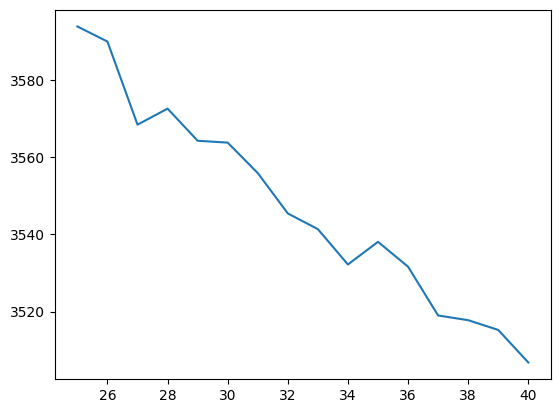

In [25]:
clusters_list = []
inertia_list = []
for i in range(25,41):
    cluster_model = KMeans(i).fit(x_train_tf)
    clusters_list.append(i)
    inertia_list.append(cluster_model.inertia_)

plt.plot(clusters_list, inertia_list)
plt.show()

Taking number of clusters as 37, we will now fit this model and transform the data to cluster data space. Also predict the labels for validation dataset

In [45]:
cluster_model = KMeans(37).fit(x_train_tf)
x_train_clus = cluster_model.transform(x_train_tf)
rep_class_idx = np.argmin(x_train_clus, axis=0)
x_rep_class = x_train_tf[rep_class_idx]
y_rep_class = np.array(y_train)[rep_class_idx]

val_clus_pred = cluster_model.predict(x_val_tf)
y_valid_pred = []
for i in val_clus_pred:
    y_valid_pred.append(y_rep_class[i])

print(classification_report(y_val, y_valid_pred, zero_division=1))

              precision    recall  f1-score   support

         ham       0.88      1.00      0.94       736
        spam       1.00      0.00      0.00       100

    accuracy                           0.88       836
   macro avg       0.94      0.50      0.47       836
weighted avg       0.89      0.88      0.82       836



Predicting for test dataset

In [46]:
test_clus_pred = cluster_model.predict(x_test_tf)
y_test_pred = []
for i in test_clus_pred:
    y_test_pred.append(y_rep_class[i])

print(classification_report(y_test, y_test_pred, zero_division=1))

              precision    recall  f1-score   support

         ham       0.86      1.00      0.92       720
        spam       1.00      0.00      0.00       117

    accuracy                           0.86       837
   macro avg       0.93      0.50      0.46       837
weighted avg       0.88      0.86      0.80       837



### Conclusion

The Logistic Regression model performed the best among all three and will be selected for further use on this dataset

## Assignment 2

### Defining bencmarking functions for all models

#### Model 1: Multinomial Naive Bayes

In [8]:
def mnb_model(x_train_tf, y_train, x_val_tf, y_val, a):
    multi_nb_spam_model = MultinomialNB(alpha = a).fit(x_train_tf, y_train)
    y_pred = multi_nb_spam_model.predict(x_val_tf)
    
    acc_score = accuracy_score(y_val, y_pred)
    
    # Computing Precision and Recall
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    aupcr = auc(recall, precision)

    return [acc_score, aupcr]

#### Model 2: Logistic Regression

In [9]:
def lr_model(x_train_tf, y_train, x_val_tf, y_val, c_value):
    log_reg_model = LogisticRegression(C = c_value, max_iter=10000)
    log_reg_model.fit(x_train_tf, y_train)
    y_pred = log_reg_model.predict(x_val_tf)
    
    acc_score = accuracy_score(y_val, y_pred)
    
    # Computing Precision and Recall
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    aupcr = auc(recall, precision)

    return [acc_score, aupcr]

#### Model 3: Semi-Supervised Clustering

In [10]:
def kmeans_model(x_train_tf, y_train, x_val_tf, y_val, clusters):
    cluster_model = KMeans(clusters).fit(x_train_tf)
    x_train_clus = cluster_model.transform(x_train_tf)
    rep_class_idx = np.argmin(x_train_clus, axis=0)
    x_rep_class = x_train_tf[rep_class_idx]
    y_rep_class = np.array(y_train)[rep_class_idx]

    val_clus_pred = cluster_model.predict(x_val_tf)
    y_valid_pred = []
    for i in val_clus_pred:
        y_valid_pred.append(y_rep_class[i])
    
    acc_score = accuracy_score(y_val, y_valid_pred)
    
    # Computing Precision and Recall
    precision, recall, thresholds = precision_recall_curve(y_val, y_valid_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    aupcr = auc(recall, precision)

    return [acc_score, aupcr]

### Running and Tracking Benchmarking experiments with MLFlow

In [11]:
client = mlflow.MlflowClient()
#log into MLflow

#Set storage directory
mlflow.set_tracking_uri('../tracking/MLFlow_Logs/mlruns')

#set experiment
mlflow.set_experiment('SMS Spam Classification Model Evaluation')

2023/02/26 19:42:35 INFO mlflow.tracking.fluent: Experiment with name 'SMS Spam Classification Model Evaluation' does not exist. Creating a new experiment.


<Experiment: artifact_location='../tracking/MLFlow_Logs/mlruns/217659261940286806', creation_time=1677420755636, experiment_id='217659261940286806', last_update_time=1677420755636, lifecycle_stage='active', name='SMS Spam Classification Model Evaluation', tags={}>

In [12]:
md_name = "Multinomial Naive Bayes" 
for i in np.arange(0.05, 2.25, 0.25):
    with mlflow.start_run() as run: #inside brackets run_name='test'
        #Log parameters
        mlflow.log_param("Model",md_name)
        mlflow.log_param("Alpha",i)
        #Running the model
        model_metrics = mnb_model(x_train_tf, y_train, x_val_tf, y_val, i)
        #Logging metrics
        mlflow.log_metric("Accuracy", model_metrics[0])
        mlflow.log_metric("AUPCR", model_metrics[1])

md_name = "Logistic Regression"
for i in [0.1, 0.5, 1, 10, 20, 50, 100]:
    with mlflow.start_run() as run: 
        #Log parameters
        mlflow.log_param("Model",md_name)
        mlflow.log_param("C",i)
        #Running the model
        model_metrics = lr_model(x_train_tf, y_train, x_val_tf, y_val, i)
        #Logging metrics
        mlflow.log_metric("Accuracy", model_metrics[0])
        mlflow.log_metric("AUPCR", model_metrics[1])


md_name = "Semi-Supervised Clustering"
for i in range(25,41):
    with mlflow.start_run() as run: 
        #Log parameters
        mlflow.log_param("Model",md_name)
        mlflow.log_param("Clusters",i)
        #Running the model
        model_metrics = kmeans_model(x_train_tf, y_train, x_val_tf, y_val, i)
        #Logging metrics
        mlflow.log_metric("Accuracy", model_metrics[0])
        mlflow.log_metric("AUPCR", model_metrics[1])